In [1]:
#importing necessary packages
!pip install optuna
import optuna
import torch
import random
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import torch.nn.functional as F
from csv import writer
import seaborn as sns
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [ ]:
# if running with Google Colab, enter the right path from your Drive
# otherwise completely comment this cell

from google.colab import drive
drive.mount('/content/drive')
%cd "/content/drive/Othercomputers/My MacBook Pro (1)/SolvingEulersElastica/DiscreteNetwork"

In [3]:
from Scripts.GetData import getDataLoaders, loadData
from Scripts.Training import train
from Scripts.PlotResults import plotResults
from Scripts.SavedParameters import hyperparams

In [4]:
#setting plotting parameters
sns.set_style("darkgrid")
sns.set(font = "Times New Roman")
sns.set_context("paper")
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'STIXGeneral'
plt_kws = {"rasterized": True}

In [5]:
torch.set_default_dtype(torch.float32)

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [7]:
# both-ends only: datacase == 1
# train on both-ends, test on right-end: datacase == 2
# train and test on both-ends + right-end: datacase == 3

datacase = input("Choose datacase ")
datacase = int(datacase)

Choose datacase 1


In [8]:
if datacase == 1:
    percentage_train = input("Choose percentage of training data between 90, 40, 20, and 10: ")
    percentage_train = int(percentage_train)/100
    percentage_train
else:
    percentage_train = 0.9

Choose percentage of training data between 90, 40, 20, and 10: 90


In [9]:
torch.manual_seed(1)
np.random.seed(1)
random.seed(1)

In [10]:
class approximate_curve(nn.Module):
        def __init__(self, is_res = True, normalize = True, act_name='tanh', nlayers=3, hidden_nodes = 50, output_dim = 204):
          super().__init__()

          torch.manual_seed(1)
          np.random.seed(1)
          random.seed(1)
          self.act_dict = {"tanh":lambda x : torch.tanh(x),
                            "sigmoid":lambda x : torch.sigmoid(x),
                            "swish":lambda x : x*torch.sigmoid(x),
                            "relu":lambda x : torch.relu(x),
                            "lrelu":lambda x : F.leaky_relu(x)}
          self.is_norm = normalize
          self.is_res = is_res
          self.act = self.act_dict[act_name]
          self.nlayers = nlayers
          self.first = nn.Linear(8,hidden_nodes)
          self.linears = nn.ModuleList([nn.Linear(hidden_nodes,hidden_nodes) for i in range(self.nlayers)])
          self.last = nn.Linear(hidden_nodes,output_dim)

        def forward(self,x):

            if self.is_norm:
                x[:,0] = (x[:,0]-1.5)/1.5
                x[:,4] = (x[:,4]-1.5)/1.5
            x  = self.act(self.first(x))
            for i in range(self.nlayers):
                if self.is_res: #ResNet
                    x = x + self.act(self.linears[i](x))
                else: #MLP
                    x = self.act(self.linears[i](x))

            return self.last(x)

In [11]:
num_nodes, trajectories_train, trajectories_test = loadData(datacase)

In [12]:
def define_model(trial):
    torch.manual_seed(1)
    np.random.seed(1)
    random.seed(1)
    is_res = trial.suggest_categorical("is_res",[True,False])
    normalize = trial.suggest_categorical("normalize",[True,False])
    act_name = trial.suggest_categorical("act",['tanh','swish','sigmoid','relu','lrelu'])
    nlayers = trial.suggest_int("n_layers", 0, 4)
    hidden_nodes = trial.suggest_int("hidden_nodes", 32, 1024)

    model = approximate_curve(is_res, normalize, act_name, nlayers, hidden_nodes,output_dim=int(4*(num_nodes-2)))
    return model

In [13]:
from torch.utils.data import Dataset, DataLoader

In [14]:
def objective(trial):

    torch.manual_seed(1)
    np.random.seed(1)
    random.seed(1)

    # Generate the model
    model = define_model(trial)
    model.to(device);

    lr = trial.suggest_float("lr", 1e-4 , 1e-1, log=True)
    weight_decay = trial.suggest_float("weight_decay",1e-7,5e-4,log=True)
    gamma = trial.suggest_float("gamma",0,1e-2) #smoothing regularization
    optimizer = torch.optim.Adam(model.parameters(),lr=lr,weight_decay=weight_decay)

    criterion = nn.MSELoss()

    batch_size = trial.suggest_categorical("batch_size", [32, 64, 128])
    x_train, y_train, x_test, y_test, trainloader,testloader = getDataLoaders(batch_size, datacase, percentage_train)

    print("Current test with :\n\n")
    for key, value in trial.params.items():
      print("    {}: {}".format(key, value))
    print("\n\n")

    epochs = 300
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = epochs//3, gamma = 0.1)
    loss = train(model,gamma,criterion,scheduler,optimizer,epochs,trainloader,testloader,device)
    print('Loss ',loss.item())
    error = 1000

    if not torch.isnan(loss):
        model.eval();

        learned_traj = np.zeros_like(y_test)

        for i in range(len(x_test)):
            bcsol =  torch.from_numpy(x_test[i:i+1].astype(np.float32)).to(device)
            learned_traj[i] = model(bcsol)[0].detach().cpu().numpy()
        error = np.mean((learned_traj - y_test)**2)
        print(learned_traj.shape, y_test.shape)
        print(f"The error on the test trajectories is: {error}.")


    datanames = ["both_ends", "both_ends_right_end"]
    if datacase == 1:
        dataname = datanames[0]
    if datacase == 3:
        dataname = datanames[1]

    #Saving the obtained results
    if trial.number == 0:
        labels = []
        for lab, _ in trial.params.items():
            labels.append(str(lab))
        labels.append("MSE")
        with open("SavedResults.csv", "a") as f_object:
            writer_object = writer(f_object)
            writer_object.writerow(labels)
            writer_object.writerow(f"\n\n Datacase: {dataname}, Percentage of training data: {percentage_train}")
            f_object.close()

    results = []
    for _, value in trial.params.items():
        results.append(str(value))

    results.append(error)

    with open("SavedResults.csv", "a") as f_object:
        writer_object = writer(f_object)
        writer_object.writerow(results)
        f_object.close()
    return error

In [15]:
optuna_study = input("Do you want to do hyperparameter test? Type yes or no: ")
params = {}
if optuna_study=="yes":
    optuna_study = True
else:
    optuna_study = False
if optuna_study:
    study = optuna.create_study(direction="minimize",study_name="Euler Elastica")
    study.optimize(objective, n_trials=300)
    print("Study statistics: ")
    print("Number of finished trials: ", len(study.trials))
    params = study.best_params

Do you want to do hyperparameter test? Type yes or no: no


In [16]:
torch.manual_seed(1)
np.random.seed(1)
random.seed(1)

In [17]:
manual_input = False
if params=={}:
    # We can input them manually by uncommenting the lines below
    if manual_input:
        print("No parameters have been specified. Let's input them:\n\n")
        is_res = input("Is_res True or False? ")=="True"
        normalize = input("Normalize is True or False? ")=="True"
        act = input("What activation function to use? Choose among 'sin', 'sigmoid', 'swish', 'tanh' ")
        nlayers = int(input("How many layers do you want the network to have? "))
        hidden_nodes = int(input("How many hidden nodes do you want the network to have? "))
        lr = float(input("What learning rate do you want to use? "))
        weight_decay = float(input("What weight decay do you want to use? "))
        gamma = float(input("What value do you want for gamma? "))
        batch_size = int(input("What batch size do you want? "))

        params = {'is_res': is_res,
                'normalize': normalize,
                'act': act,
                'n_layers': nlayers,
                'hidden_nodes': hidden_nodes,
                'lr': lr,
                'weight_decay': weight_decay,
                'gamma': gamma,
                'batch_size': batch_size}
    else:
    # or we can use the combinations found by Optuna that yield the best results for the mentioned datacases
        params = hyperparams(datacase, percentage_train)

In [18]:
print(f'The hyperparameters yelding the best results for this case are: {params}')

The hyperparameters yelding the best results for this case are: {'is_res': False, 'normalize': True, 'act': 'tanh', 'n_layers': 4, 'hidden_nodes': 879, 'lr': 0.0013780948769418003, 'weight_decay': 1.535048308234182e-07, 'gamma': 0.004242492350411101, 'batch_size': 32}


In [19]:
def define_best_model():
    torch.manual_seed(1)
    np.random.seed(1)
    random.seed(1)

    normalize = params["normalize"]
    act = params["act"]
    nlayers = params["n_layers"]
    hidden_nodes = params["hidden_nodes"]
    is_res = params["is_res"]

    model = approximate_curve(is_res, normalize, act, nlayers, hidden_nodes, int(4*(num_nodes-2)))

    return model

In [20]:
model = define_best_model()
model.to(device);

In [21]:
TrainMode = input("Train Mode True or False? Type 0 for False and 1 for True: ")
TrainMode = int(TrainMode)
if TrainMode == 0:
    TrainMode = False
else:
    TrainMode = True
TrainMode

Train Mode True or False? Type 0 for False and 1 for True: 0


False

In [22]:
weight_decay = params["weight_decay"]
lr = params["lr"]
gamma = params["gamma"]
batch_size = params["batch_size"]
epochs = 300
optimizer = torch.optim.Adam(model.parameters(),lr=lr,weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = epochs//3, gamma = 0.1)
criterion = nn.MSELoss()
x_train, y_train, x_test, y_test, trainloader, testloader = getDataLoaders(batch_size, datacase, percentage_train)
model.to(device);

if TrainMode:
    loss = train(model,gamma,criterion,scheduler,optimizer,epochs,trainloader,testloader,device)
    if datacase == 1:
        if percentage_train == 0.9:
            torch.save(model.state_dict(), 'TrainedModels/BothEnds0.9data.pt')
        elif percentage_train == 0.4:
            torch.save(model.state_dict(), 'TrainedModels/BothEnds0.4data.pt')
        elif percentage_train == 0.2:
            torch.save(model.state_dict(), 'TrainedModels/BothEnds0.2data.pt')
        else:
            torch.save(model.state_dict(), 'TrainedModels/BothEnds0.1data.pt')
    if datacase == 2:
        torch.save(model.state_dict(), 'TrainedModels/BothEndsExtrapolation0.9data.pt')
    if datacase == 3:
        torch.save(model.state_dict(), 'TrainedModels/BothEndsRightEnd0.9data.pt')
else:
    if datacase == 1:
        if percentage_train == 0.9:
            pretrained_dict = torch.load(f'TrainedModels/BothEnds0.9data.pt',map_location=device)
        elif percentage_train == 0.4:
            pretrained_dict = torch.load(f'TrainedModels/BothEnds0.4data.pt',map_location=device)
        elif percentage_train == 0.2:
            pretrained_dict = torch.load(f'TrainedModels/BothEnds0.2data.pt',map_location=device)
        else:
            pretrained_dict = torch.load(f'TrainedModels/BothEnds0.1data.pt',map_location=device)
    if datacase == 2:
        pretrained_dict = torch.load(f'TrainedModels/BothEndsExtrapolation0.9data.pt',map_location=device)
    if datacase == 3:
        pretrained_dict = torch.load(f'TrainedModels/BothEndsRightEnd0.9data.pt',map_location=device)
    model.load_state_dict(pretrained_dict)
model.eval();

In [23]:
torch.manual_seed(1)
np.random.seed(1)
random.seed(1)

model.eval();


 Error over training trajectories: 2.791964349225609e-07, 
 Error over test trajectories: 3.028041142373076e-07, 
 Error over all trajectories: 2.8156437844045347e-07.


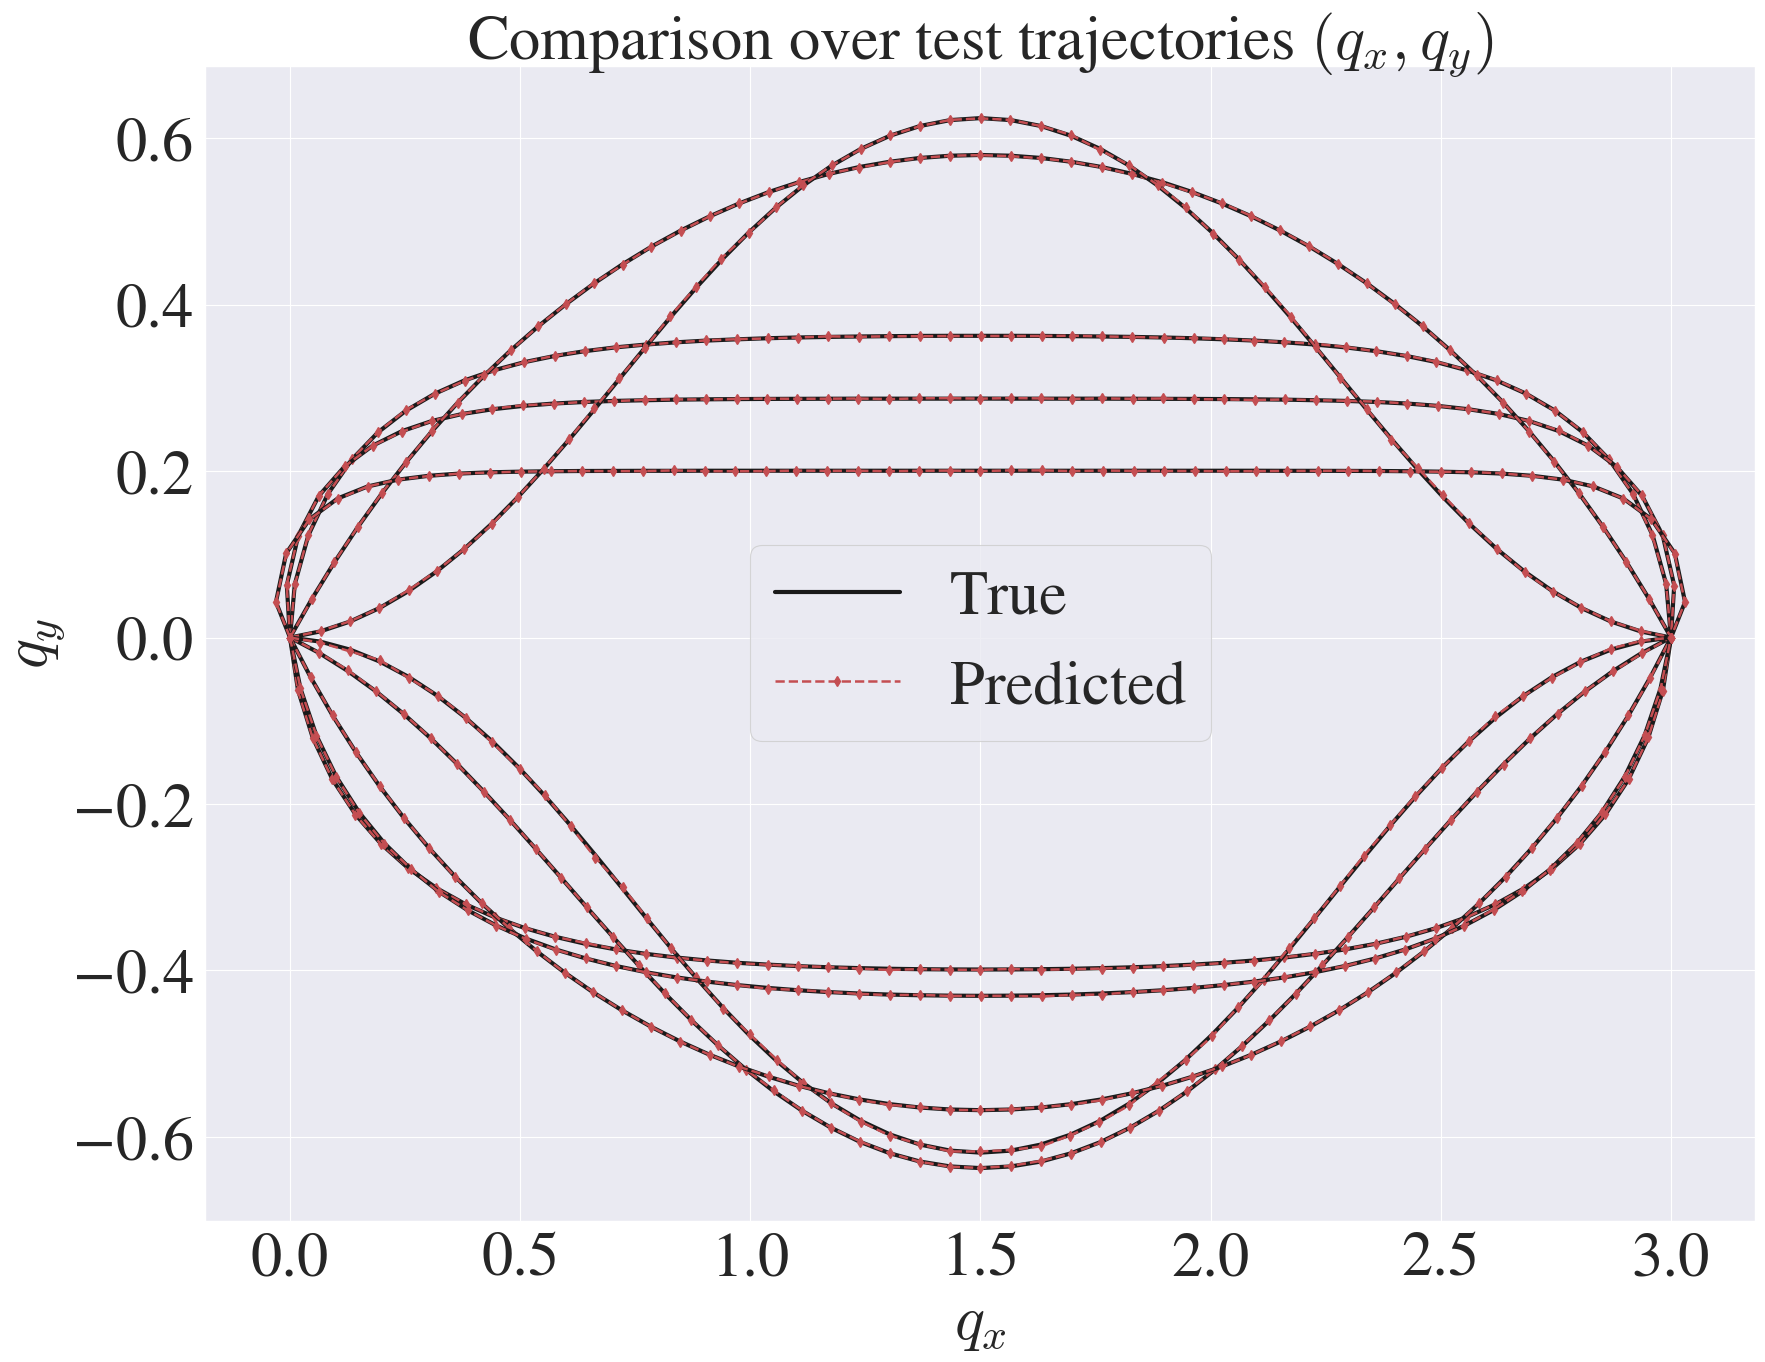

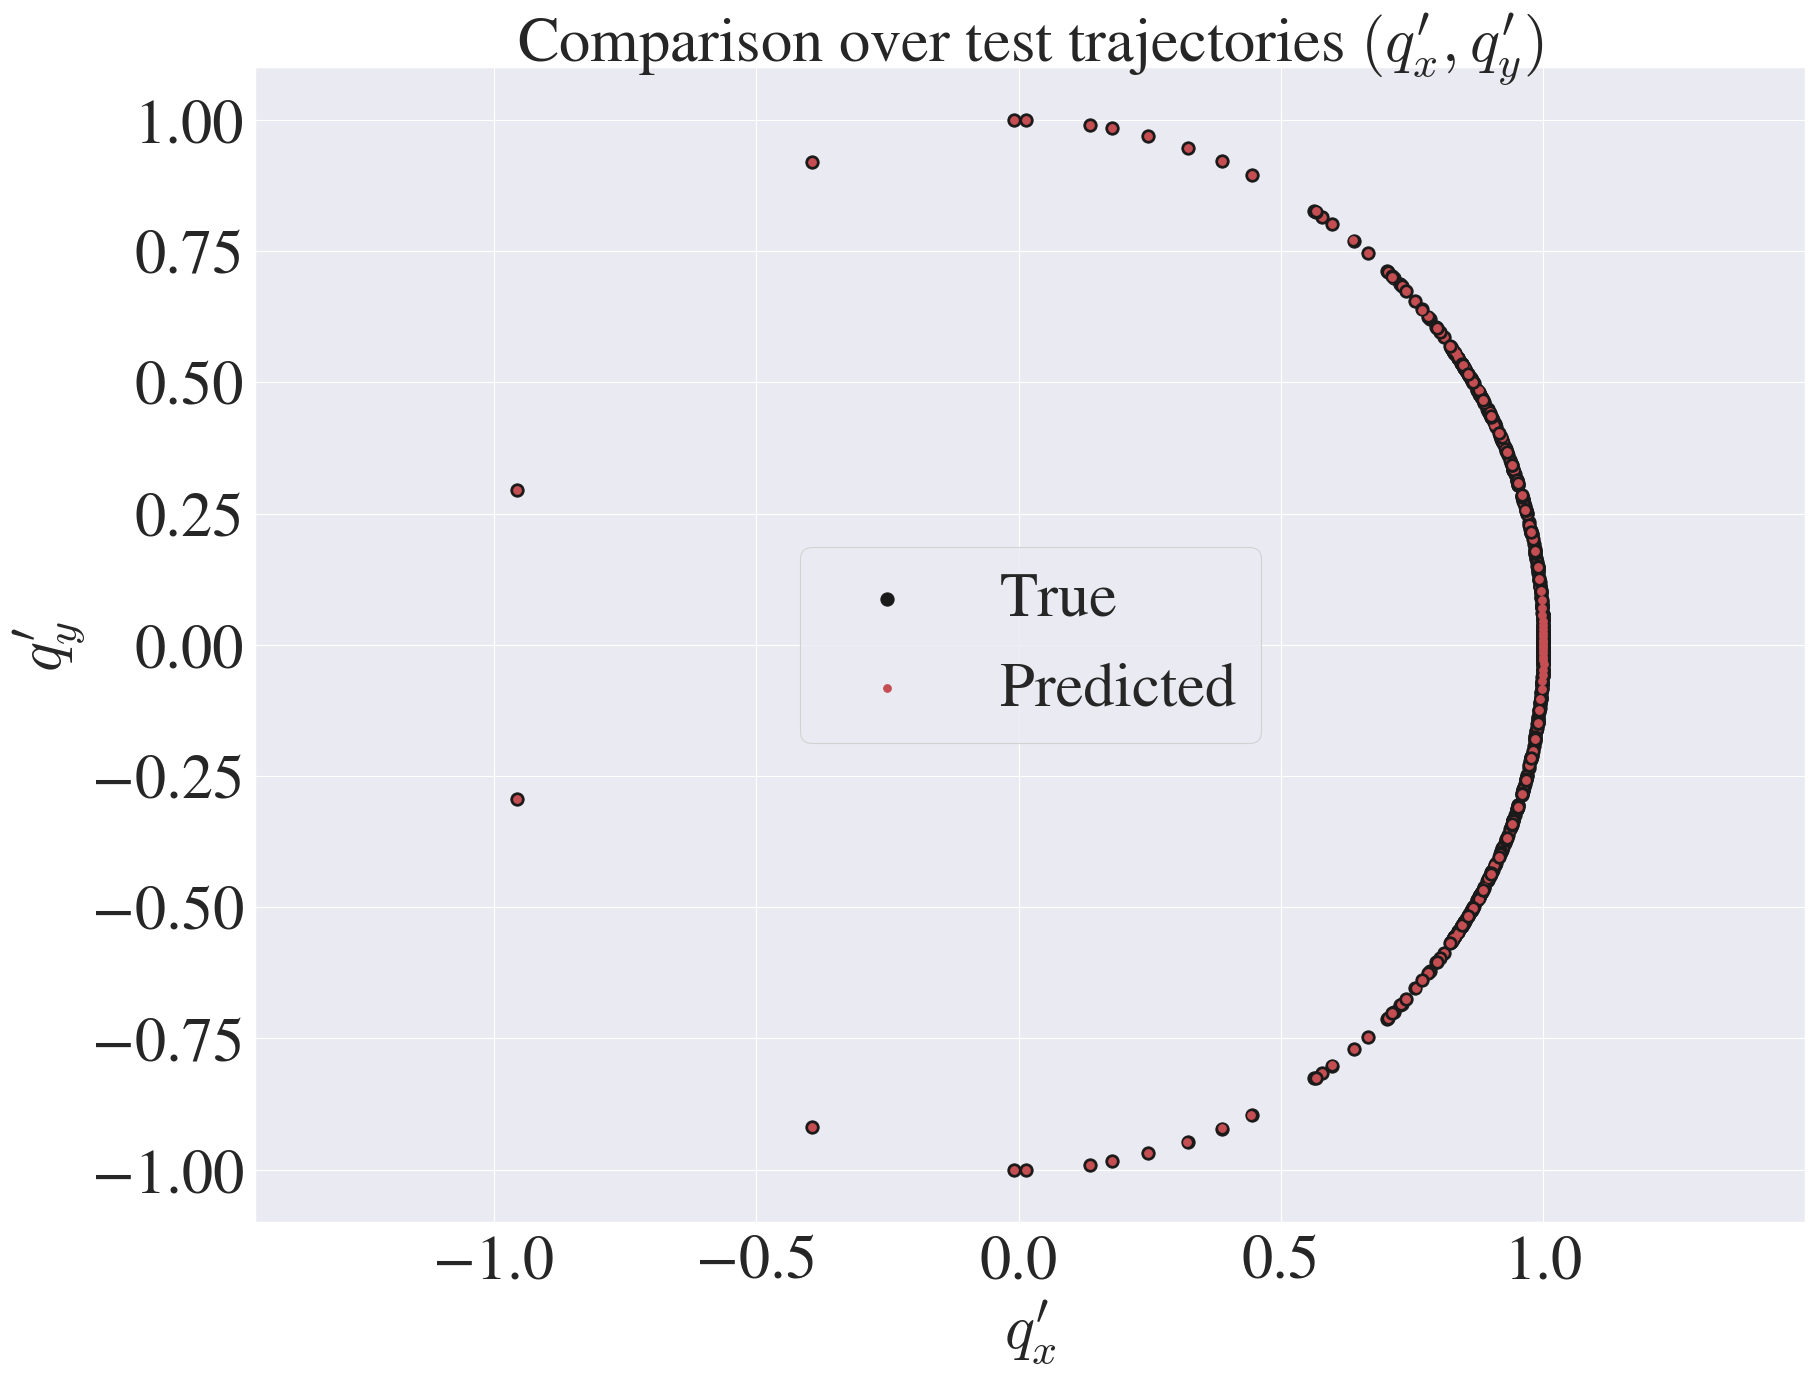

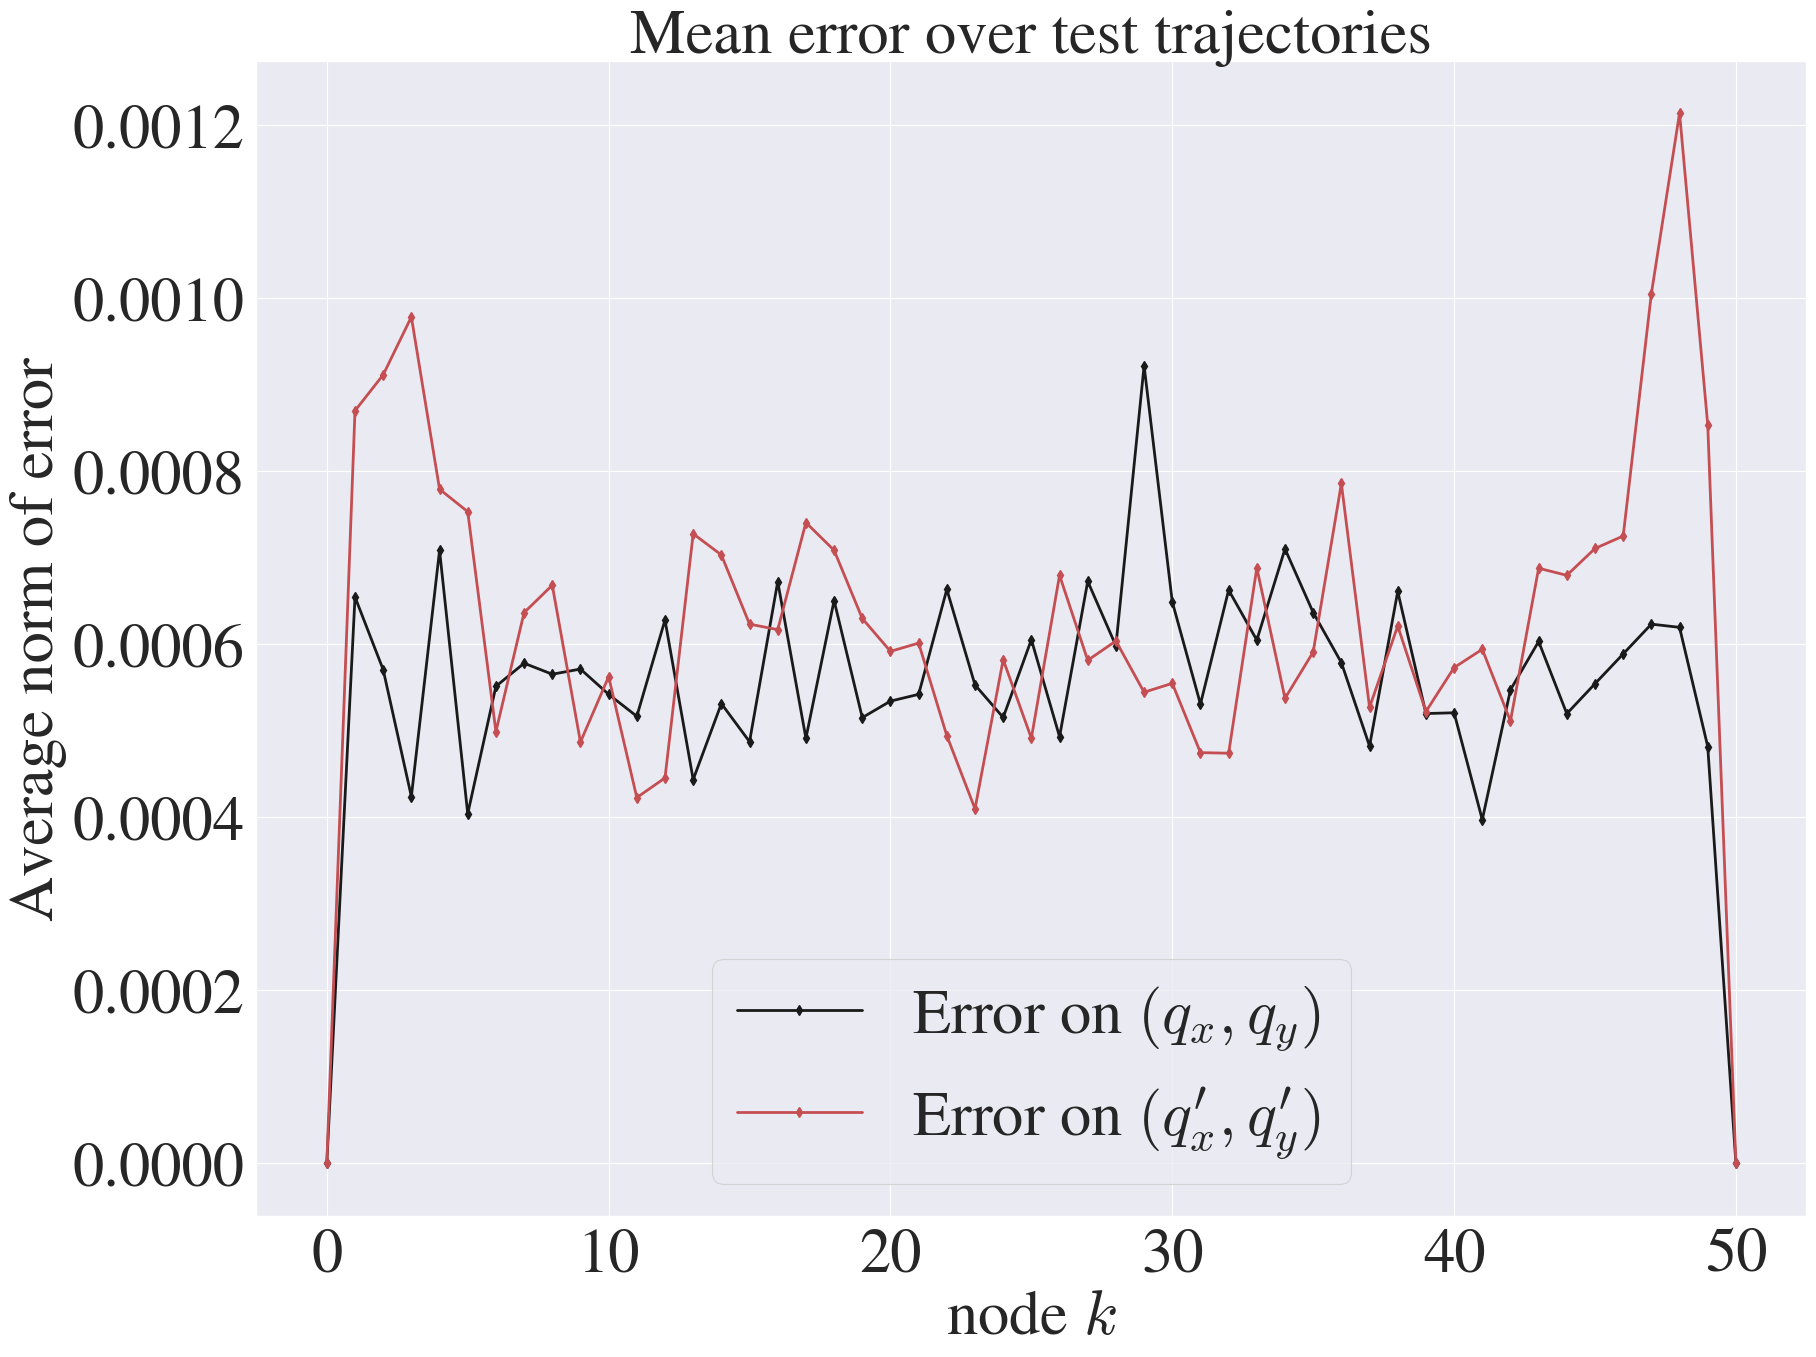

In [24]:
# printing the accuracies and plotting the results
plotResults(model, device, x_train, y_train, x_test, y_test, num_nodes, datacase, percentage_train)